## MOLGAN EXAMPLE

In [1]:
import tensorflow as tf

from utils.sparse_molecular_dataset import SparseMolecularDataset
from utils.trainer import Trainer
from utils.utils import *

from models.gan import GraphGANModel
from models import encoder_rgcn, decoder_adj, decoder_dot, decoder_rnn

from optimizers.gan import GraphGANOptimizer

batch_dim = 128
la = 1
dropout = 0
n_critic = 5
metric = 'validity,sas'
n_samples = 5000
z_dim = 8
epochs = 10
save_every = 1 # May lead to errors if left as None

data = SparseMolecularDataset()
data.load('data/gdb9_9nodes.sparsedataset')

steps = (len(data) // batch_dim)


def train_fetch_dict(i, steps, epoch, epochs, min_epochs, model, optimizer):
    a = [optimizer.train_step_G] if i % n_critic == 0 else [optimizer.train_step_D]
    b = [optimizer.train_step_V] if i % n_critic == 0 and la < 1 else []
    return a + b


def train_feed_dict(i, steps, epoch, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_train_batch(batch_dim)
    embeddings = model.sample_z(batch_dim)

    if la < 1:

        if i % n_critic == 0:
            rewardR = reward(mols)

            n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                               feed_dict={model.training: False, model.embeddings: embeddings})
            n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
            mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

            rewardF = reward(mols)

            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.rewardR: rewardR,
                         model.rewardF: rewardF,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}

        else:
            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}
    else:
        feed_dict = {model.edges_labels: a,
                     model.nodes_labels: x,
                     model.embeddings: embeddings,
                     model.training: True,
                     model.dropout_rate: dropout,
                     optimizer.la: 1.0}

    return feed_dict


def eval_fetch_dict(i, epochs, min_epochs, model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def eval_feed_dict(i, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_validation_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict


def test_fetch_dict(model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def test_feed_dict(model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_test_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict


def reward(mols):
    rr = 1.
    for m in ('logp,sas,qed,unique' if metric == 'all' else metric).split(','):

        if m == 'np':
            rr *= MolecularMetrics.natural_product_scores(mols, norm=True)
        elif m == 'logp':
            rr *= MolecularMetrics.water_octanol_partition_coefficient_scores(mols, norm=True)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores(mols, norm=True)
        elif m == 'novelty':
            rr *= MolecularMetrics.novel_scores(mols, data)
        elif m == 'dc':
            rr *= MolecularMetrics.drugcandidate_scores(mols, data)
        elif m == 'unique':
            rr *= MolecularMetrics.unique_scores(mols)
        elif m == 'diversity':
            rr *= MolecularMetrics.diversity_scores(mols, data)
        elif m == 'validity':
            rr *= MolecularMetrics.valid_scores(mols)
        else:
            raise RuntimeError('{} is not defined as a metric'.format(m))

    return rr.reshape(-1, 1)


def _eval_update(i, epochs, min_epochs, model, optimizer, batch_dim, eval_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0


def _test_update(model, optimizer, batch_dim, test_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0


# model
model = GraphGANModel(data.vertexes,
                      data.bond_num_types,
                      data.atom_num_types,
                      z_dim,
                      decoder_units=(128, 256, 512),
                      discriminator_units=((128, 64), 128, (128, 64)),
                      decoder=decoder_adj,
                      discriminator=encoder_rgcn,
                      soft_gumbel_softmax=False,
                      hard_gumbel_softmax=False,
                      batch_discriminator=False)

# optimizer
optimizer = GraphGANOptimizer(model, learning_rate=1e-3, feature_matching=False)

# session
session = tf.Session()
session.run(tf.global_variables_initializer())

# trainer
trainer = Trainer(model, optimizer, session)

print('Parameters: {}'.format(np.sum([np.prod(e.shape) for e in session.run(tf.trainable_variables())])))

trainer.train(batch_dim=batch_dim,
              epochs=epochs,
              steps=steps,
              train_fetch_dict=train_fetch_dict,
              train_feed_dict=train_feed_dict,
              eval_fetch_dict=eval_fetch_dict,
              eval_feed_dict=eval_feed_dict,
              test_fetch_dict=test_fetch_dict,
              test_feed_dict=test_feed_dict,
              save_every=save_every,
              directory='Model_Output', # here users need to first create and then specify a folder where to save the model
              _eval_update=_eval_update,
              _test_update=_test_update)





Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




2025-07-15 11:48:05.434494: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-15 11:48:05.470392: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999965000 Hz
2025-07-15 11:48:05.472462: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559b61a73860 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-07-15 11:48:05.472588: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 8 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info 


Parameters: 575556
2025-07-15 11:48:10 Epochs          0/10 in 0:00:00 (last epoch in 0:00:00), ETA: -:--:-


OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8337 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8434 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8435 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8436 thread 4 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8336 thread 5 bound to OS proc set 5
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8437 thread 6 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8439 thread 8 bound to OS proc set 0
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8438 thread 7 bound to OS proc set 7
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8441 thread 9 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8442 thread 10 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8443 thread 11 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8444 thread 12 bound to OS proc set 4
[11:48:52] Explicit valence for atom 

2025-07-15 11:49:44 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333935,
 'la': 1.0,
 'logP score': nan,
 'loss D': -0.7588314,
 'loss G': 0.2354715,
 'loss RL': -0.4996959,
 'loss V': 0.35003904,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}



/home/silkenmocha/Documentos/MolGAN/utils/molecular_metrics.py:60: RuntimeWarning: Mean of empty slice.
  return MolecularMetrics.novel_scores(MolecularMetrics.valid_filter(mols), data).mean()
/home/silkenmocha/anaconda3/envs/molgan/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/silkenmocha/anaconda3/envs/molgan/lib/python3.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice.


2025-07-15 11:49:48 Model saved in Model_Output!


OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8617 thread 13 bound to OS proc set 5
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8618 thread 14 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8619 thread 15 bound to OS proc set 7
OMP: Info #254: KMP_AFFINITY: pid 7946 tid 8620 thread 16 bound to OS proc set 0


 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 11:53:55 Epochs          1/10 in 0:05:44 (last epoch in 0:04:06), ETA: 0:51:44


[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] non-ring atom 5 marked aromatic
[11:54:34] non-ring atom 5 marked aromatic
[11:54:34] non-ring atom 5 marked aromatic
[11:54:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:54:34] non-ring atom 1 marked aromatic
[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] Explicit valence for atom # 3 O, 3, is greater than permitted
[11:54:34] Explicit valen

2025-07-15 11:57:08 Validation --> {'NP score': 0.8606409590575329,
 'QED score': 0.5202252251992635,
 'SA score': 0.6273324652008871,
 'diversity score': 0.6883202667189098,
 'drugcandidate score': 0.4259224860708391,
 'la': 1.0,
 'logP score': 0.37001711619280864,
 'loss D': -64.436295,
 'loss G': 29.566698,
 'loss RL': -0.43844482,
 'loss V': 0.29447833,
 'novel score': 100.0,
 'unique score': 0.8715300193673339,
 'valid score': 61.959999799728394}
2025-07-15 11:57:13 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:02:00 Epochs          2/10 in 0:13:50 (last epoch in 0:04:47), ETA: 0:55:22


[12:02:21] non-ring atom 2 marked aromatic
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 2 marked aromatic
[12:02:21] non-ring atom 2 marked aromatic
[12:02:21] non-ring atom 2 marked aromatic
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 2 marked aromatic
[12:02:21] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] Explicit valence for atom # 5 C, 5, is greater than permitted
[12:02:21] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:02:21] Explicit valence for atom # 3 O, 3, is greater than permitted
[12:02:21] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:02:21] non-ring atom 1 marked aromatic
[12:02:21] non-ring atom 2 marked

2025-07-15 12:03:41 Validation --> {'NP score': 0.6794560415258599,
 'QED score': 0.5899184271118711,
 'SA score': 0.5757619279768282,
 'diversity score': 0.9117904904853004,
 'drugcandidate score': 0.47335566980418486,
 'la': 1.0,
 'logP score': 0.42859066503559334,
 'loss D': -99.5253,
 'loss G': 50.604935,
 'loss RL': -0.41822973,
 'loss V': 0.18834145,
 'novel score': 82.07625939326468,
 'unique score': 0.4731422209852491,
 'valid score': 71.85999751091003}
2025-07-15 12:03:42 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:05:32 Epochs          3/10 in 0:17:22 (last epoch in 0:01:49), ETA: 0:40:32


[12:05:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:05:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:05:45] Can't kekulize mol.  Unkekulized atoms: 1
[12:05:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:05:45] Explicit valence for atom # 3 O, 3, is greater than permitted
[12:05:45] Can't kekulize mol.  Unkekulized atoms: 1
[12:05:45] Can't kekulize mol.  Unkekulized atoms: 1
[12:05:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:05:45] Can't kekulize mol.  Unkekulized atoms: 1
[12:05:45] Explicit valence for atom # 7 C, 6, is greater than permitted
[12:05:45] Can't kekulize mol.  Unkekulized atoms: 1
[12:05:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[12:05:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:05:45] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:05:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:0

2025-07-15 12:06:52 Validation --> {'NP score': 0.9335917629618191,
 'QED score': 0.496978199196458,
 'SA score': 0.3392540103392462,
 'diversity score': 0.7203677424426004,
 'drugcandidate score': 0.49635346113148787,
 'la': 1.0,
 'logP score': 0.37285090233370555,
 'loss D': -110.26667,
 'loss G': 58.967415,
 'loss RL': -0.4372258,
 'loss V': 0.25394812,
 'novel score': 100.0,
 'unique score': 3.0246189917936697,
 'valid score': 85.29999852180481}
2025-07-15 12:06:53 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:08:06 Epochs          4/10 in 0:19:56 (last epoch in 0:01:12), ETA: 0:29:54


[12:08:18] Explicit valence for atom # 0 N, 5, is greater than permitted
[12:08:18] Explicit valence for atom # 0 N, 11, is greater than permitted
[12:08:18] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:08:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:08:18] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:08:18] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:08:18] Explicit valence for atom # 3 O, 6, is greater than permitted
[12:08:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:08:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:08:18] Explicit valence for atom # 7 C, 6, is greater than permitted
[12:08:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[12:08:18] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:08:18] Explicit valence for atom # 3 O, 4, is greater than permitted
[12:08:18] Explicit valence for atom # 4 O, 3, is 

2025-07-15 12:09:18 Validation --> {'NP score': 0.970936626675791,
 'QED score': 0.512677819628886,
 'SA score': 0.22978465673605739,
 'diversity score': 0.611081429246568,
 'drugcandidate score': 0.4138511981495265,
 'la': 1.0,
 'logP score': 0.33233553951148126,
 'loss D': -118.29869,
 'loss G': 60.91877,
 'loss RL': -0.41941348,
 'loss V': 0.22316872,
 'novel score': 100.0,
 'unique score': 4.008016032064128,
 'valid score': 69.85999941825867}
2025-07-15 12:09:19 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:10:35 Epochs          5/10 in 0:22:25 (last epoch in 0:01:15), ETA: 0:22:25


[12:10:48] Explicit valence for atom # 3 O, 3, is greater than permitted
[12:10:48] Can't kekulize mol.  Unkekulized atoms: 7
[12:10:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:10:48] Explicit valence for atom # 3 O, 3, is greater than permitted
[12:10:48] non-ring atom 0 marked aromatic
[12:10:48] Can't kekulize mol.  Unkekulized atoms: 7
[12:10:48] non-ring atom 0 marked aromatic
[12:10:48] Can't kekulize mol.  Unkekulized atoms: 7
[12:10:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:10:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:10:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:10:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:10:48] Can't kekulize mol.  Unkekulized atoms: 7
[12:10:48] non-ring atom 4 marked aromatic
[12:10:48] Can't kekulize mol.  Unkekulized atoms: 7
[12:10:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:10:48] Explicit va

2025-07-15 12:11:47 Validation --> {'NP score': 0.9821674112179589,
 'QED score': 0.5097255022928291,
 'SA score': 0.27790145643475095,
 'diversity score': 0.5373009144064592,
 'drugcandidate score': 0.4064951504212411,
 'la': 1.0,
 'logP score': 0.3653554469596342,
 'loss D': -115.75211,
 'loss G': 59.090515,
 'loss RL': -0.423073,
 'loss V': 0.2329881,
 'novel score': 100.0,
 'unique score': 4.700981850639691,
 'valid score': 67.22000241279602}
2025-07-15 12:11:48 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:12:57 Epochs          6/10 in 0:24:46 (last epoch in 0:01:08), ETA: 0:16:31


[12:13:09] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:13:09] Explicit valence for atom # 3 O, 3, is greater than permitted
[12:13:09] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:13:09] Can't kekulize mol.  Unkekulized atoms: 7
[12:13:09] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:13:09] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:13:09] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:13:09] Explicit valence for atom # 8 F, 3, is greater than permitted
[12:13:09] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:13:09] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:13:09] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:13:09] Explicit valence for atom # 3 O, 3, is greater than permitted
[12:13:09] Explicit valence for atom # 3 O, 3, is greater than permitted
[12:13:09] Can't kekulize mol.  Unkekulized atoms: 7
[12:13:09] Explici

2025-07-15 12:14:22 Validation --> {'NP score': 0.9339440956116362,
 'QED score': 0.5105899824819369,
 'SA score': 0.4560725984625501,
 'diversity score': 0.6664550073514074,
 'drugcandidate score': 0.5534877601256303,
 'la': 1.0,
 'logP score': 0.34563742556782934,
 'loss D': -119.63746,
 'loss G': 64.07641,
 'loss RL': -0.4423088,
 'loss V': 0.20075317,
 'novel score': 99.04160313657155,
 'unique score': 5.489000217817469,
 'valid score': 91.82000160217285}
2025-07-15 12:14:23 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:15:33 Epochs          7/10 in 0:27:23 (last epoch in 0:01:10), ETA: 0:11:44


[12:15:45] Explicit valence for atom # 0 N, 9, is greater than permitted
[12:15:45] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:15:45] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:15:45] Explicit valence for atom # 0 N, 6, is greater than permitted
[12:15:45] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:15:45] Explicit valence for atom # 0 O, 13, is greater than permitted
[12:15:45] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:15:45] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:15:45] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:15:45] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:15:45] Explicit valence for atom # 6 C, 5, is greater than permitted
[12:15:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[12:15:45] Explicit valence for atom # 6 C, 5, is greater than permitted
[12:15:45] Explicit valence for atom # 3 O, 5, is 

2025-07-15 12:16:52 Validation --> {'NP score': 0.9773552435040088,
 'QED score': 0.4934059426524834,
 'SA score': 0.3512427703175955,
 'diversity score': 0.7352316041969921,
 'drugcandidate score': 0.43339825354028183,
 'la': 1.0,
 'logP score': 0.3592398549991824,
 'loss D': -121.417534,
 'loss G': 65.85335,
 'loss RL': -0.41840726,
 'loss V': 0.22323437,
 'novel score': 97.5107296137339,
 'unique score': 6.5522174535050075,
 'valid score': 69.90000009536743}
2025-07-15 12:16:53 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:18:12 Epochs          8/10 in 0:30:02 (last epoch in 0:01:18), ETA: 0:07:30


[12:18:24] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:18:24] Explicit valence for atom # 2 C, 8, is greater than permitted
[12:18:24] Explicit valence for atom # 8 C, 5, is greater than permitted
[12:18:24] Explicit valence for atom # 5 N, 6, is greater than permitted
[12:18:24] Can't kekulize mol.  Unkekulized atoms: 1
[12:18:24] Explicit valence for atom # 7 C, 5, is greater than permitted
[12:18:24] Explicit valence for atom # 8 C, 6, is greater than permitted
[12:18:24] Can't kekulize mol.  Unkekulized atoms: 2 5 6
[12:18:24] Explicit valence for atom # 5 N, 6, is greater than permitted
[12:18:24] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:18:24] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:18:24] Can't kekulize mol.  Unkekulized atoms: 0
[12:18:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:18:24] Explicit valence for atom # 7 C, 5, is greater than permitted
[12:18:24] Explicit valence for at

2025-07-15 12:19:34 Validation --> {'NP score': 0.9658911783646248,
 'QED score': 0.494958644231742,
 'SA score': 0.29003535361453425,
 'diversity score': 0.5521465194372999,
 'drugcandidate score': 0.4585782463774798,
 'la': 1.0,
 'logP score': 0.35882978697489837,
 'loss D': -117.45077,
 'loss G': 62.530346,
 'loss RL': -0.42461988,
 'loss V': 0.22185755,
 'novel score': 98.61704802615037,
 'unique score': 6.4370128237364845,
 'valid score': 79.54000234603882}
2025-07-15 12:19:36 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:20:57 Epochs          9/10 in 0:32:47 (last epoch in 0:01:21), ETA: 0:03:38


[12:21:11] Can't kekulize mol.  Unkekulized atoms: 2
[12:21:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[12:21:11] non-ring atom 4 marked aromatic
[12:21:11] non-ring atom 0 marked aromatic
[12:21:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:21:11] non-ring atom 2 marked aromatic
[12:21:11] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:21:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:21:11] non-ring atom 2 marked aromatic
[12:21:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:21:11] Explicit valence for atom # 1 O, 3, is greater than permitted
[12:21:11] Explicit valence for atom # 4 O, 3, is greater than permitted
[12:21:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:21:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:21:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:21:11] Explicit valence for atom # 5 C, 5

2025-07-15 12:22:12 Validation --> {'NP score': 0.9664775477274942,
 'QED score': 0.5014824277018918,
 'SA score': 0.3074447809723893,
 'diversity score': 0.4979785509820093,
 'drugcandidate score': 0.44594874160886,
 'la': 1.0,
 'logP score': 0.34792435789639836,
 'loss D': -122.698524,
 'loss G': 65.41746,
 'loss RL': -0.4170294,
 'loss V': 0.22701593,
 'novel score': 99.86648865153538,
 'unique score': 6.835781041388518,
 'valid score': 74.90000128746033}
2025-07-15 12:22:13 Model saved in Model_Output!
 100% (1040/1040) [################################################################################] ETA: 0:00:00
2025-07-15 12:23:28 Epochs         10/10 in 0:35:18 (last epoch in 0:01:15), ETA: 0:00:00


[12:23:44] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:23:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:44] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:23:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:44] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:23:44] Explicit valence for atom # 0 N, 8, is greater than permitted
[12:23:44] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:23:44] non-ring atom 0 marked aromatic
[12:23:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:44] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:23:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:23:4

2025-07-15 12:24:44 Validation --> {'NP score': 0.9801552587836176,
 'QED score': 0.4819768077264331,
 'SA score': 0.3163338765050688,
 'diversity score': 0.5602264967410601,
 'drugcandidate score': 0.41772713917767196,
 'la': 1.0,
 'logP score': 0.3603095869022501,
 'loss D': -113.36925,
 'loss G': 66.83099,
 'loss RL': -0.4080167,
 'loss V': 0.22334085,
 'novel score': 99.74093264248705,
 'unique score': 6.966033390903857,
 'valid score': 69.48000192642212}
2025-07-15 12:24:45 Model saved in Model_Output!
INFO:tensorflow:Restoring parameters from Model_Output/model.ckpt
2025-07-15 12:24:46 Model loaded from Model_Output!
2025-07-15 12:24:46 End of training (10 epochs) in 0:36:36


[12:24:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:24:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:24:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:24:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:24:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:24:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:24:59] Explicit valence for atom # 1 O, 3, is g

2025-07-15 12:26:05 Test --> {'NP score': 0.9798788267700393,
 'QED score': 0.48259728788708034,
 'SA score': 0.3166172314994497,
 'diversity score': 0.44281609531499816,
 'drugcandidate score': 0.4181326229514452,
 'la': 1.0,
 'logP score': 0.3595358627163759,
 'loss D': -113.32282,
 'loss G': 66.9382,
 'loss RL': -0.40646473,
 'loss V': 0.22183505,
 'novel score': 99.7413049726933,
 'unique score': 6.639839034205232,
 'valid score': 69.58000063896179}


Tipo de objeto devuelto: <class 'IPython.core.display.Image'>


[13:05:12] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:05:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:05:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:05:12] Explicit valence for atom # 0 N, 6, is greater than permitted
[13:05:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:05:12] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:05:12] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:05:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:05:12] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:05:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:05:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:05:12] Explicit valence for atom # 2 N, 4, is greater than permitted


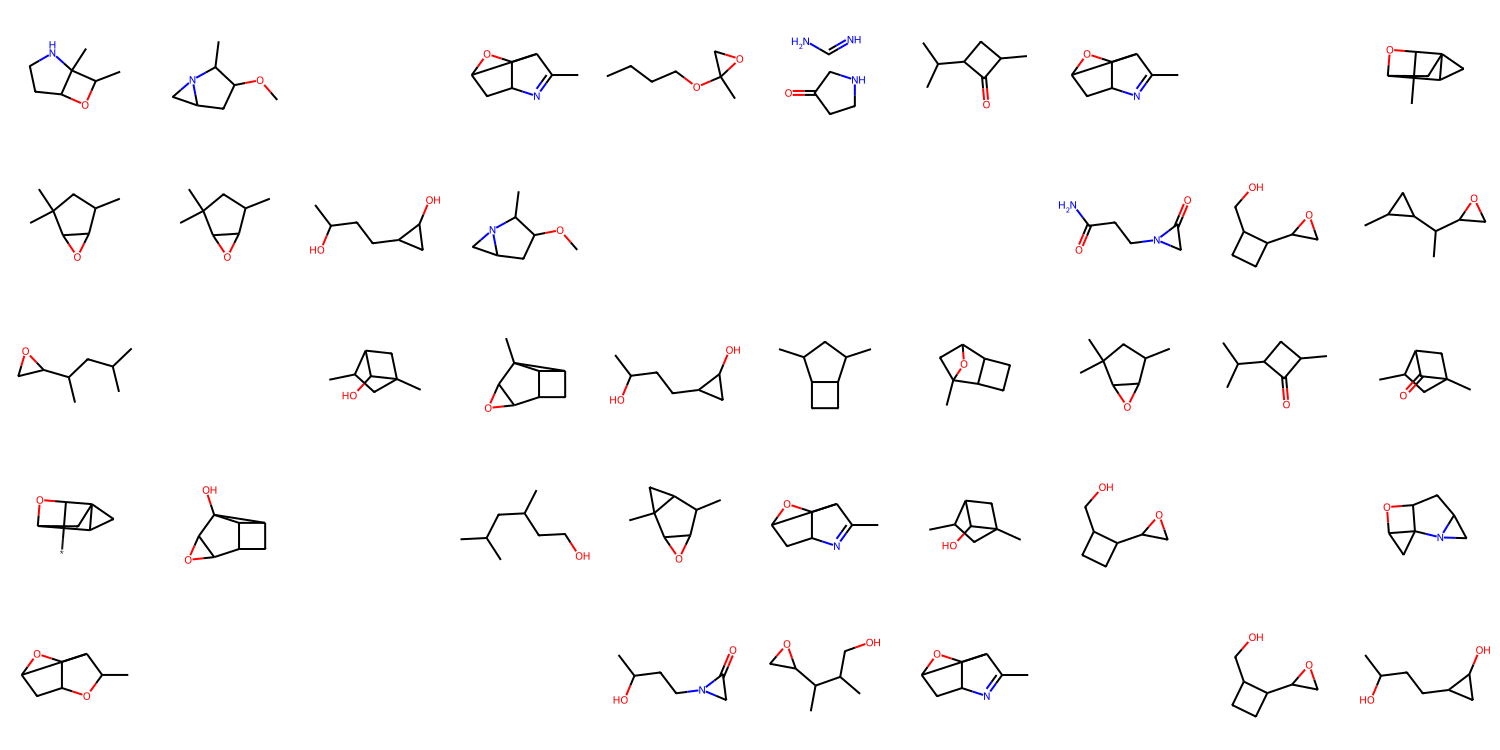

In [20]:
def visualizar_moleculas(mols, mols_por_fila=5, guardar_como=None):
    img = mols2grid_image(mols, mols_por_fila)
    print("Tipo de objeto devuelto:", type(img))  # <<< Añade esto

    if guardar_como:
        try:
            img.save(guardar_como)
        except Exception as e:
            print(f"No se pudo guardar la imagen: {e}")
    else:
        try:
            img.show()
        except AttributeError:
            from IPython.display import display
            display(img)

mols = samples(data, model, session, model.sample_z(50), sample=True)
visualizar_moleculas(mols, mols_por_fila=10)
